In [1]:
import pandas as pd
from RoutePlanner.CellGrid import CellGrid
from matplotlib import pyplot as plt
import xarray as xr
import netCDF4 as nc
import datetime
from RoutePlanner.TemporalCellGrid import TemporalCellGrid
import matplotlib.pyplot as plt
from RoutePlanner.CellBox import CellBox

In [2]:
def loadIce(icePointsPath, startTime, endTime):
    icePoints = xr.open_dataset(icePointsPath)
    ipSlice = icePoints.sel(time=slice(startTime, endTime))
    ipSlice = ipSlice.to_dataframe()
    
    ipSlice = ipSlice.reset_index()
    ipSlice = ipSlice.rename(columns={'XC':'long', 'YC':'lat', 'Depth':'depth', 'SIarea':'iceArea'})
    ipSlice['long'] = ipSlice['long'].apply(lambda x: x if x <= 180 else x - 360)
  
    return ipSlice

In [3]:
sose = nc.Dataset("data/SOSE_surface_velocity_6yearMean_2005-2010.nc")

currentPoints = pd.DataFrame({'long': sose['lon'][...].data.flatten(),
                                'lat': sose['lat'][...].data.flatten(),
                                'uC': sose['uC'][...].data.flatten(),
                                'vC': sose['vC'][...].data.flatten()})

currentPoints['time'] = ''
currentPoints['uC'] = currentPoints['uC'] * 3.6
currentPoints['vC'] = currentPoints['vC'] * 3.6
currentPoints['long'] = currentPoints['long'].apply(lambda x: x if x <= 180 else x - 360)

print(currentPoints)

            long        lat        uC        vC time
0       0.083333 -77.874969       NaN       NaN     
1       0.250000 -77.874969       NaN       NaN     
2       0.416667 -77.874969       NaN       NaN     
3       0.583333 -77.874969       NaN       NaN     
4       0.750000 -77.874969       NaN       NaN     
...          ...        ...       ...       ...  ...
691195 -0.750000 -24.708300  0.002377 -0.122380     
691196 -0.583313 -24.708300  0.002553 -0.119374     
691197 -0.416656 -24.708300  0.002715 -0.116243     
691198 -0.250000 -24.708300  0.002877 -0.112676     
691199 -0.083313 -24.708300  0.002877 -0.108961     

[691200 rows x 5 columns]


In [4]:
modis_ips = pd.read_csv('Modis_1km.csv')
modis_ips = modis_ips.rename(columns ={'0':'long', '1':'lat', '2':'time', '3':'iceArea', '4':'cloud'})
modis_ips['iceArea'] = modis_ips['iceArea'] * 0.1

modis_ips = modis_ips[modis_ips.cloud != 1]

modis_ips = modis_ips.drop(columns = ['Unnamed: 0', 'cloud'])
print(modis_ips)

               long        lat        time  iceArea
155      -63.639404 -59.998535  19-02-2017      0.5
177      -63.446045 -59.998535  19-02-2017      0.5
178      -63.437256 -59.998535  19-02-2017      0.5
180      -63.419678 -59.998535  19-02-2017      0.5
181      -63.410889 -59.998535  19-02-2017      0.6
...             ...        ...         ...      ...
14243203 -10.043701 -79.993652  19-02-2017      0.5
14243204 -10.034912 -79.993652  19-02-2017      0.5
14243205 -10.026123 -79.993652  19-02-2017      0.5
14243206 -10.017334 -79.993652  19-02-2017      0.5
14243207 -10.008545 -79.993652  19-02-2017      0.4

[8449828 rows x 4 columns]


In [5]:
icePointsPath = "data/bsose_i122_2013to2017_1day_SeaIceArea.nc"

startTime = '2017-02-19'
endTime = '2017-02-19'

bsose = loadIce(icePointsPath, startTime, endTime)
bsose = bsose.drop(columns = ['iter', 'rA', 'iceArea'])
print(bsose)

              time      long        lat        depth
0       2017-02-19  0.083333 -77.982651     0.000000
1       2017-02-19  0.083333 -77.947899     0.000000
2       2017-02-19  0.083333 -77.913048     0.000000
3       2017-02-19  0.083333 -77.878098     0.000000
4       2017-02-19  0.083333 -77.843056     0.000000
...            ...       ...        ...          ...
1270075 2017-02-19 -0.083313 -30.305382  4520.000000
1270076 2017-02-19 -0.083313 -30.161386  4287.402832
1270077 2017-02-19 -0.083313 -30.017181  4520.000000
1270078 2017-02-19 -0.083313 -29.870987  4798.514648
1270079 2017-02-19 -0.083313 -29.715317  4736.891602

[1270080 rows x 4 columns]


In [6]:
latMin = -80
latMax = -60
longMin = -65
longMax = -10

cellWidth = 5
cellHeight = 2.5

modis_grid = CellGrid(longMin, longMax, latMin, latMax, cellWidth, cellHeight)
modis_grid.addIcePoints(modis_ips)
modis_grid.addCurrentPoints(currentPoints)
modis_grid.addDataPoints(bsose)

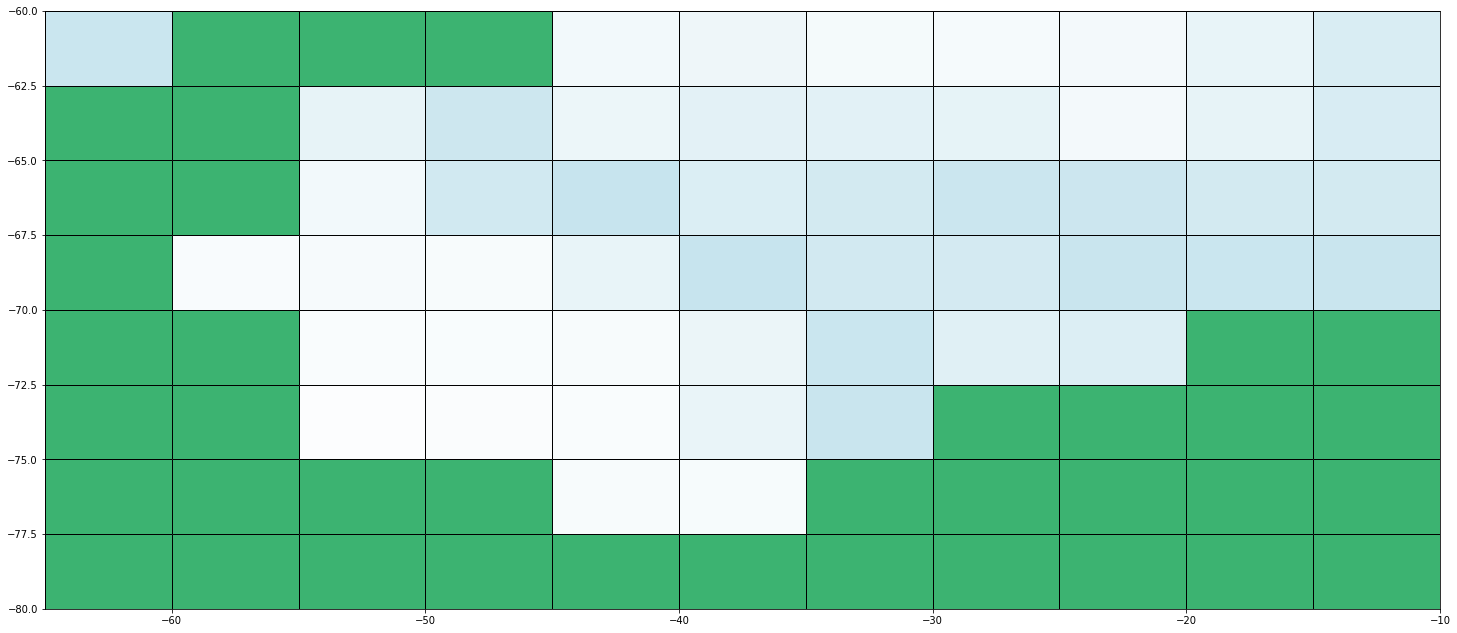

In [7]:
modis_grid.plot()

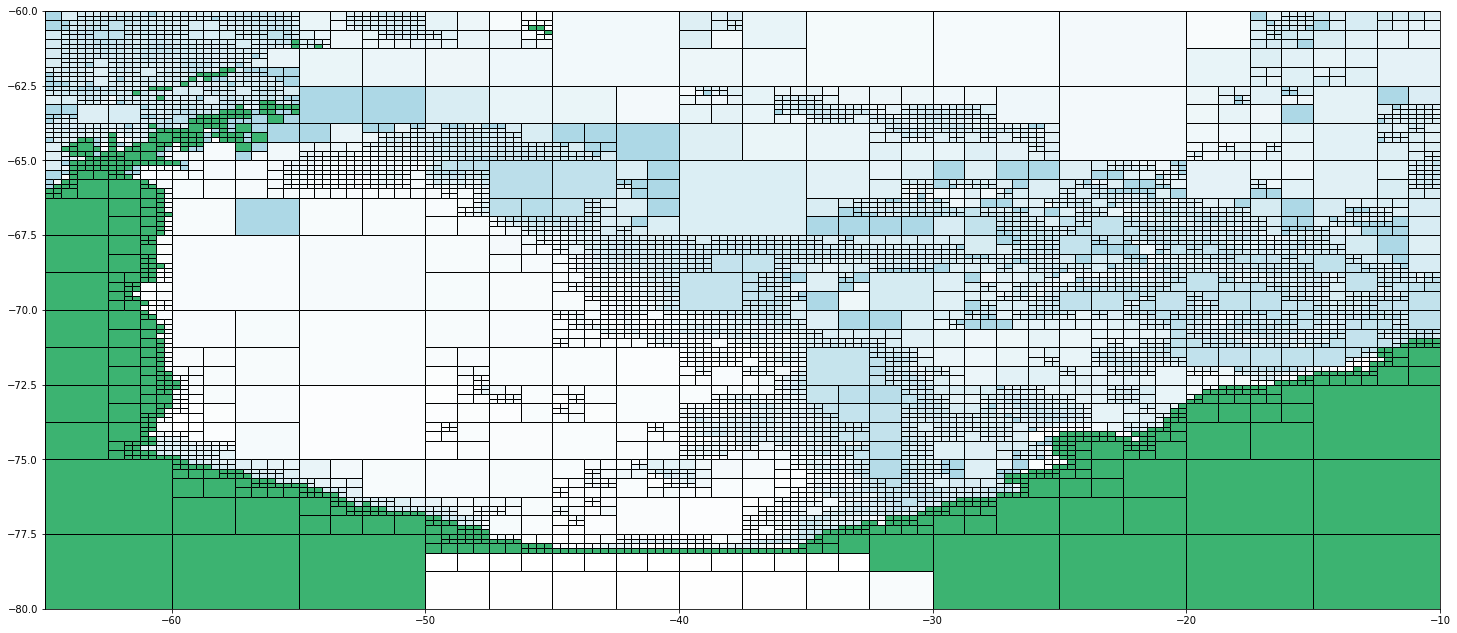

In [8]:
splittingPercentage = 0.35 # thershold
splitMinProp = 0.3 # lowerbound
splitMaxProp = 1.0 # upperbound

modis_grid.iterativeSplit(4, splittingPercentage, splitMinProp, splitMaxProp)
modis_grid.plot()

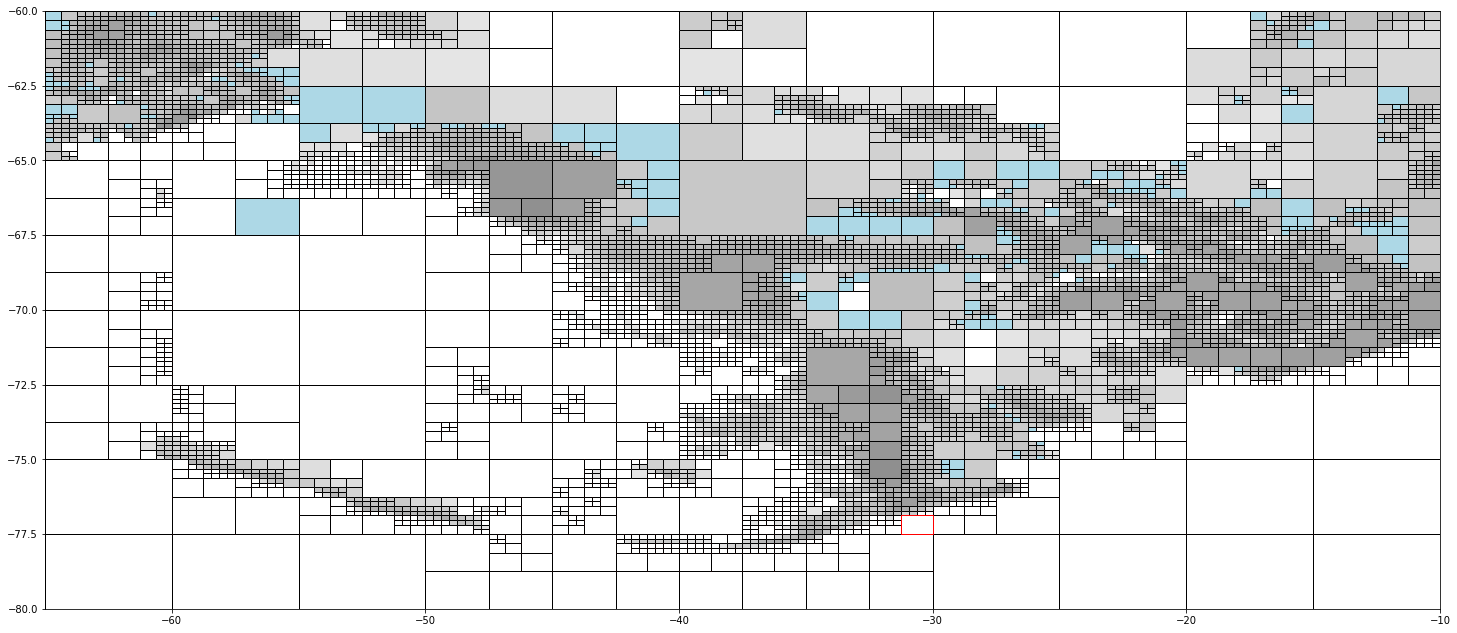

In [31]:
cellBox = modis_grid.cellBoxes[431]
modis_grid.plot(highlightCellBoxes = {cellBox})

In [32]:
print(cellBox.getDataPoints())

               long        lat                 time  iceArea  uC  vC  depth
12025459 -31.242920 -76.882324           19-02-2017      0.8 NaN NaN    NaN
12025460 -31.234131 -76.882324           19-02-2017      0.8 NaN NaN    NaN
12025461 -31.225342 -76.882324           19-02-2017      0.9 NaN NaN    NaN
12025462 -31.216553 -76.882324           19-02-2017      0.9 NaN NaN    NaN
12025463 -31.207764 -76.882324           19-02-2017      0.9 NaN NaN    NaN
...             ...        ...                  ...      ...  ..  ..    ...
1163678  -30.083313 -77.046249  2017-02-19 00:00:00      NaN NaN NaN    0.0
1163679  -30.083313 -77.008835  2017-02-19 00:00:00      NaN NaN NaN    0.0
1163680  -30.083313 -76.971313  2017-02-19 00:00:00      NaN NaN NaN    0.0
1163681  -30.083313 -76.933685  2017-02-19 00:00:00      NaN NaN NaN    0.0
1163682  -30.083313 -76.895950  2017-02-19 00:00:00      NaN NaN NaN    0.0

[10222 rows x 7 columns]


In [9]:
iceThershold = 0.8
cellsOverBound = []

for cellBox in modis_grid.cellBoxes:
    if isinstance(cellBox, CellBox):
        if cellBox.iceArea() >= iceThershold:
            cellsOverBound.append(cellBox)
        
print(len(cellsOverBound))

1179


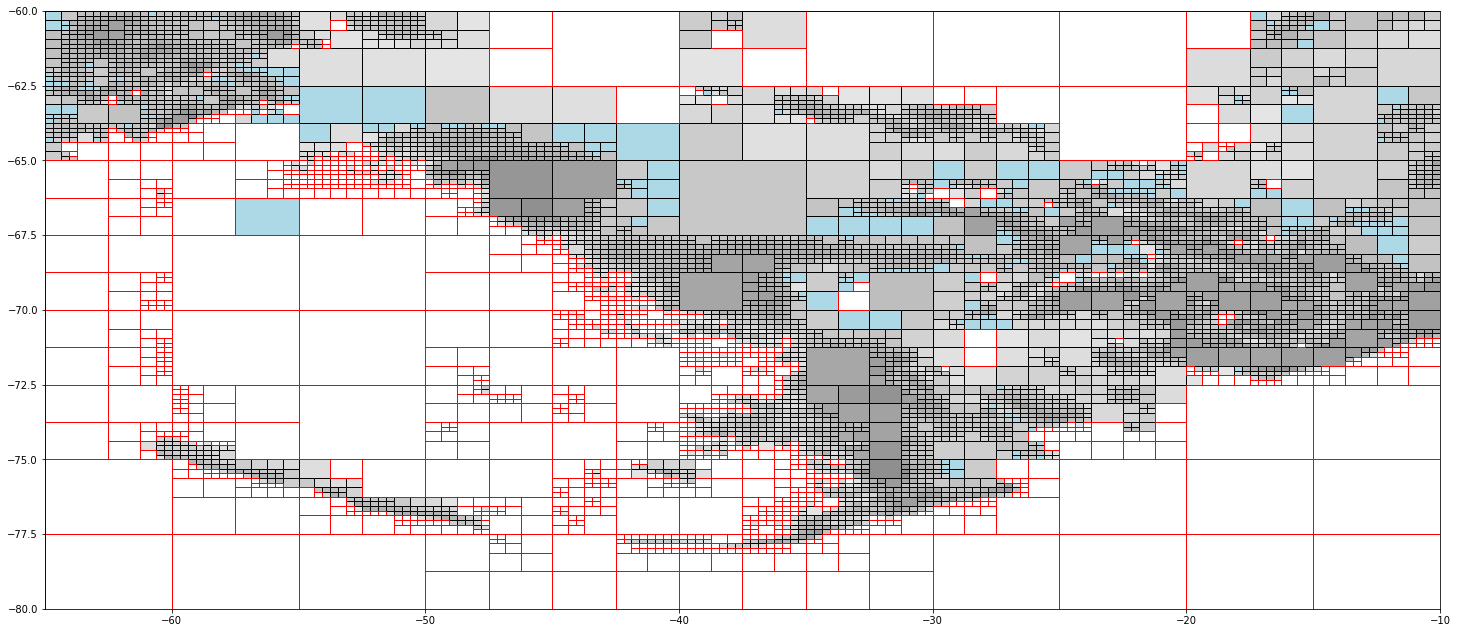

In [11]:
modis_grid.plot(highlightCellBoxes = cellsOverBound)

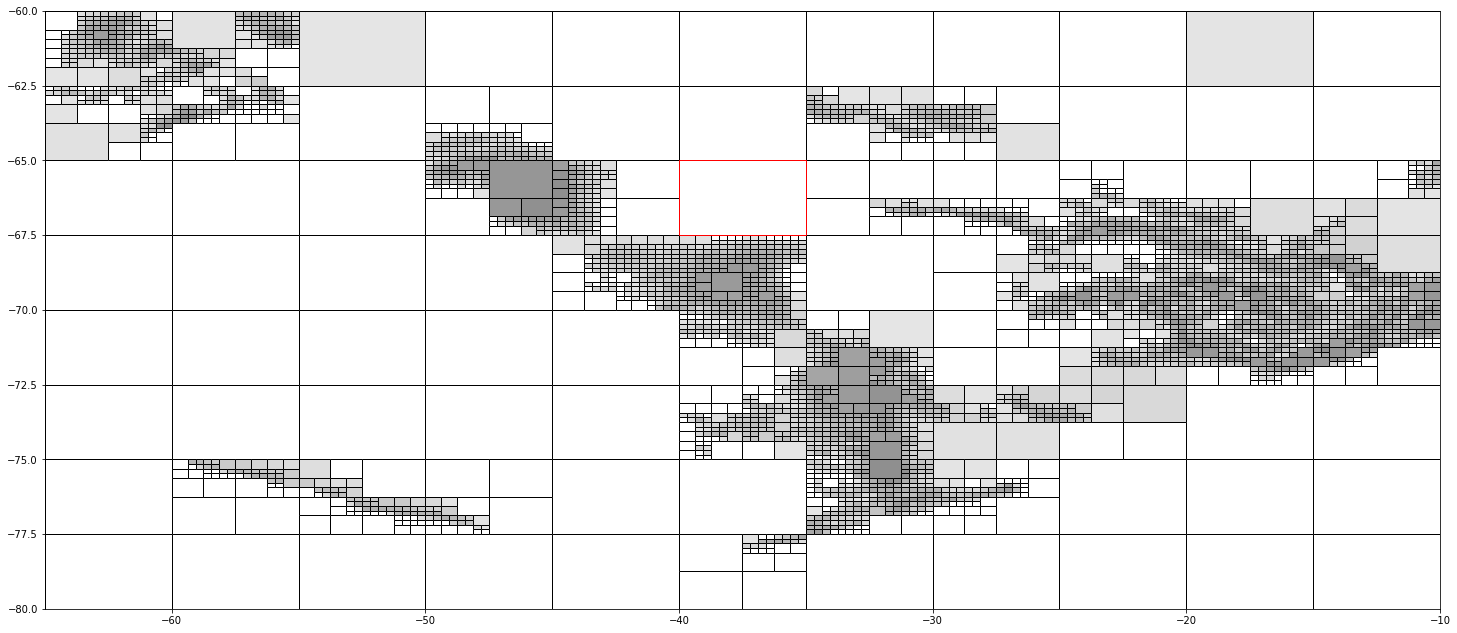

In [55]:
cellBox = modis_grid.getCellBox(-39, -66)[0]
modis_grid.plot(highlightCellBoxes = {cellBox})

In [40]:
icePoints = cellBox.getIcePoints()
print(icePoints['iceArea'].mean())

0.570754716981132


In [41]:
print(icePoints[icePoints.iceArea > splittingPercentage].shape[0] / icePoints.shape[0])

1.0
